In [ ]:
%%capture


In [2]:
import h5py
import torch
import pandas as pd
import numpy as np
from tangermeme.utils import characters
from tangermeme.seqlet import tfmodisco_seqlets
from tangermeme.plot import plot_logo
from tangermeme.utils import one_hot_encode
from tangermeme.deep_lift_shap import deep_lift_shap, _nonlinear
import torch, torch.nn as nn, torch.fx as fx, copy
import copy
import matplotlib.pyplot as plt
import statsmodels
import modiscolite

In [3]:
#get one hots

def load_attributions_with_test_index(h5_file_path):
    """
    Load scaled foreground attributions while preserving original sequence indices
    """
    with h5py.File(h5_file_path, 'r') as f:
        orig_df = pd.DataFrame(pd.read_csv('/grid/wsbs/home_norepl/pmantill/Motif_Swap_Experiments/Replicating_Motif_Swap_Manuscript/experimental_library_generation/Binned_libraries/Hk_final_df.csv'))

        # Load the attribution data (shape: 8999, 3, 249, 4)
        all_attributions = f['attributions'][:]
        print(all_attributions.shape)
        
        # Load the original indices mapping (shape: 8999,)
        #original_indices = f['original_indices'][:]
        
        # Extract scaled foreground (index 1)
        scaled_foreground_attr = torch.tensor(all_attributions[:, 1, :, :], dtype=torch.float32)
        cluster_foreground_attr = torch.tensor(all_attributions[:, 0, :, :], dtype=torch.float32)
        average_background_attr = torch.tensor(all_attributions[:, 2, :, :], dtype=torch.float32)
        test_idx = orig_df["Unnamed: 0"]
        bin = orig_df["EvoAug_Score_Hk_bin"]
        real_score = orig_df["Real_Score_Hk"]
        pred = orig_df["EvoAug_Score_Hk"]
        seq = orig_df["Sequence"]

        df = pd.DataFrame(list(zip(scaled_foreground_attr, cluster_foreground_attr, average_background_attr, test_idx, bin, real_score, pred, seq)), columns=['Scaled_foreground', 'Cluster_foreground', 'Avg_background', 'test_idx', 'bin', 'real_score', 'evoaug_pred', "str_seq"])
        
        print(df.shape)
        
        return df

h5_file_path = '/grid/wsbs/home_norepl/pmantill/Motif_Swap_Experiments/Replicating_Motif_Swap_Manuscript/SEAM_analysis/Hk_SEAM_results/Hk_task1_attributions.h5'

df = load_attributions_with_test_index(h5_file_path)



(9000, 3, 249, 4)
(9000, 8)


In [4]:
df["ohe_seq"] = None



In [5]:
ohe_seqs = []
for i in range(len(df)):
    ohe_seq = one_hot_encode(df.iloc[i]["str_seq"])
    ohe_seqs.append(ohe_seq)

df["ohe_seq"] = ohe_seqs
    
df.head()

,Scaled_foreground,Cluster_foreground,Avg_background,test_idx,bin,real_score,evoaug_pred,str_seq,ohe_seq
0,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0.)], [tensor(0.0007), tensor(1.0033e-05), tensor(-0.0001), tensor(8.3403e-05)], [tensor(2.9560e-05), tensor(0.0002), tensor(0.0004), tensor(1.0380e-05)], [tensor(0.0012), tensor(-6.4045e-05), tensor(0.0003), tensor(5.5768e-06)], [tensor(-6.1088e-05), tensor(-0.0004), tensor(-4.2219e-06), tensor(0.0005)], [tensor(-1.3898e-05), tensor(0.0002), tensor(1.6737e-05), tensor(-4.2711e-05)], [tensor(0.0002), tensor(0.0006), tensor(-0.0003), tensor(-3.7276...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0.)], [tensor(-9.2189e-09), tensor(-2.0027e-08), tensor(-2.4160e-08), tensor(-1.1285e-08)], [tensor(2.6226e-08), tensor(1.0888e-07), tensor(2.8610e-08), tensor(-1.0649e-08)], [tensor(4.5156e-07), tensor(1.7484e-08), tensor(5.0545e-08), tensor(-5.0863e-09)], [tensor(1.0490e-08), tensor(1.9073e-08), tensor(-3.4968e-09), tensor(-1.2859e-07)], [tensor(-5.7220e-08), tensor(5.0068e-07), tensor(-5.2452e-09), tensor(1.7166e-08)], [tensor(-2.0186e-08), ten...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0.)], [tensor(-0.0008), tensor(-6.3717e-05), tensor(0.0002), tensor(-7.2479e-05)], [tensor(-3.7849e-05), tensor(0.0024), tensor(-0.0003), tensor(-1.9252e-05)], [tensor(-0.0019), tensor(2.3782e-05), tensor(-9.6202e-05), tensor(-5.3048e-06)], [tensor(3.7491e-05), tensor(0.0004), tensor(5.5432e-05), tensor(-0.0009)], [tensor(-8.8155e-05), tensor(0.0018), tensor(7.5102e-06), tensor(0.0001)], [tensor(-0.0002), tensor(-0.0008), tensor(0.0003), tensor(1....",287455,Low,-0.714099,-1.120561,CACATCCACCAGCTTACAAAAGTATGCGCCGACATATATATATAAAGAGACAATATATTATAAAGAAAAATAATAGAATTAAATAACTACACTATGTTACGTTATTTTTTAAAAGGAGGGGGGTATGTGGTATGCGTACATATACATTTATAGTACATGTATACATAGAGTACAATGTTTTTAGAATAATTACATCAATCACTAACATAATTACATACGAATTGGCAGTGCTAGCATAAACAATAATGT,"[[tensor(0, dtype=torch.int8), tensor(1, dtype=torch.int8), tensor(0, dtype=torch.int8), tensor(1, dtype=torch.int8), tensor(0, dtype=torch.int8), tensor(0, dtype=torch.int8), tensor(0, dtype=torch.int8), tensor(1, dtype=torch.int8), tensor(0, dtype=torch.int8), tensor(0, dtype=torch.int8), tensor(1, dtype=torch.int8), tensor(0, dtype=torch.int8), tensor(0, dtype=torch.int8), tensor(0, dtype=torch.int8), tensor(0, dtype=torch.int8), tensor(1, dtype=torch.int8), tensor(0, dtype=torch.int8), t..."
1,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0.)], [tensor(8.2101e-05), tensor(-0.0003), tensor(0.0003), tensor(6.3056e-05)], [tensor(2.0864e-05), tensor(-0.0009), tensor(3.6603e-05), tensor(-0.0004)], [tensor(0.0007), tensor(7.7577e-05), tensor(-3.0991e-05), tensor(-1.2180e-05)], [tensor(-0.0001), tensor(-0.0002), tensor(0.0006), tensor(7.8302e-06)], [tensor(5.1146e-05), tensor(-1.4184e-05), tensor(-0.0001), tensor(-0.0002)], [tensor(-7.4387e-06), tensor(0.0001), tensor(-1.2731e-05), tensor...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0.)], [tensor(6.8337e-09), tensor(1.9742e-08), tensor(-7.4866e-07), tensor(6.0744e-09)], [tensor(-4.9354e-09), tensor(3.5136e-07), tensor(5.3151e-09), tensor(3.0372e-09)], [tensor(-4.3659e-08), tensor(1.5186e-08), tensor(1.0630e-08), tensor(2.5057e-08)], [tensor(-3.0372e-09), tensor(-2.2779e-09), tensor(1.3155e-07), tensor(-9.4912e-09)], [tensor(-5.3151e-09), tensor(3.0372e-08), tensor(-8.9293e-07), tensor(4.1761e-09)], [tensor(-1.0061e-08), tenso...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0.)], [tensor(5.1379e-05), tensor(0.0001), tensor(-0.0027), tensor(0.0001)], [tensor(1.0431e-05), tensor(-0.0021), tensor(-0.0002), tensor(0.0004)], [tensor(-0.0008), tensor(-0.0002), tensor(-2.3127e-05), tensor(3.6597e-05)], [tensor(0.0001), tensor(0.0002), tensor(-0.0029), tensor(-8.3685e-05)], [tensor(7.6354e-05), tensor(-9.3937e-05), tensor(-0.0029), tensor(0.0002)], [tensor(2.5988e-05), tensor(-0.0023), tensor(2.1160e-05), tensor(-1.3709e-06)...",41729,Low,-0.242478,-1.112688,AGCAGGCATGTGGCAAGTAGCAAAACTAGCAGCACATCCATTCCAAATCGGATGCGGATCATTTTA

In [6]:
# split by bin 

low_df = df[df["bin"] == 'Low']
mid_df = df[df["bin"] == 'Mid']
high_df = df[df["bin"] == 'High']

print(len(low_df), len(mid_df), len(high_df))

3000 3000 3000


In [7]:
# Fix typos and ensure consistent naming
low_ohe_list = low_df["ohe_seq"].values          # array of length N, each entry shape (L, 4)
low_att_list = low_df["Scaled_foreground"].values

mid_ohe_list = mid_df["ohe_seq"].values
mid_att_list = mid_df["Scaled_foreground"].values

high_ohe_list = high_df["ohe_seq"].values
high_att_list = high_df["Scaled_foreground"].values

# If entries are torch tensors, convert each to numpy float32
def to_numpy32(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy().astype('float32')
    x = np.asarray(x)
    return x.astype('float32')

low_ohe = np.stack([to_numpy32(x) for x in low_ohe_list], axis=0).transpose(0, 2, 1)   # shape (N, L, 4)
low_att = np.stack([to_numpy32(x) for x in low_att_list], axis=0)   # shape (N, L, 4)

mid_ohe = np.stack([to_numpy32(x) for x in mid_ohe_list], axis=0).transpose(0, 2, 1) 
mid_att = np.stack([to_numpy32(x) for x in mid_att_list], axis=0)

high_ohe = np.stack([to_numpy32(x) for x in high_ohe_list], axis=0).transpose(0, 2, 1) 
high_att = np.stack([to_numpy32(x) for x in high_att_list], axis=0)

print(low_ohe.shape, high_att.shape)  # Expect (N_low, L, 4) and (N_high, L, 4)


(3000, 249, 4) (3000, 249, 4)


In [8]:
assert low_ohe.shape[-1] == 4 and low_att.shape[-1] == 4
assert low_ohe.shape == low_att.shape
assert mid_ohe.shape == mid_att.shape
assert high_ohe.shape == high_att.shape


In [ ]:
import modiscolite
import numpy as np

def run_bin(ohe, att, window_size=20, flank=5):
    assert ohe.shape == att.shape and ohe.shape[-1] == 4
    ohe = ohe.astype('float32')
    att = att.astype('float32')
    pos_patterns, neg_patterns = modiscolite.tfmodisco.TFMoDISco(
        one_hot=ohe,
        hypothetical_contribs=att,
        sliding_window_size=window_size,
        flank_size=flank,
        verbose=True
    )
    return pos_patterns, neg_patterns

#pos_low, neg_low = run_bin(low_ohe, low_att)   # (N_low, L, 4)
#pos_mid, neg_mid = run_bin(mid_ohe, mid_att)   # (N_mid, L, 4)
pos_high, neg_high = run_bin(high_ohe, high_att)  # (N_high, L, 4)

Using 808 positive seqlets


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ffff432d540>>
Traceback (most recent call last):
  File "/grid/wsbs/home_norepl/pmantill/miniconda3/envs/tfmodisco_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
# Save each bin separately
modiscolite.io.save_hdf5('TF-Modisco-lite_results/h5py_files/Hk_low_bin_motifs.h5', pos_low, neg_low, 20)
modiscolite.io.save_hdf5('TF-Modisco-lite_results/h5py_files/Hk_mid_bin_motifs.h5', pos_mid, neg_mid, 20)  
modiscolite.io.save_hdf5('TF-Modisco-lite_results/h5py_files/Hk_high_bin_motifs.h5', pos_high, neg_high, 20)


In [11]:
with h5py.File('TF-Modisco-lite_results/h5py_files/Hk_low_bin_motifs.h5', 'r') as f:
    seq = f['pos_patterns']['pattern_0']['sequence'][:]  # pick one example
    ppm = seq / seq.sum(axis=1, keepdims=True)
    print(f"Bin {bin_name} PFM min/max =", ppm.min(), ppm.max())


Bin high PFM min/max = 0.0 1.0


In [1]:
import os
import subprocess
from modiscolite.util import MemeDataType
import modiscolite


# Define bins and corresponding .h5 inputs
bins = {
    'low':  'TF-Modisco-lite_results/h5py_files/Hk_low_bin_motifs.h5',
    'mid':  'TF-Modisco-lite_results/h5py_files/Hk_mid_bin_motifs.h5',
    'high': 'TF-Modisco-lite_results/h5py_files/Hk_high_bin_motifs.h5'
}

# Base directories
report_dir = 'TF-Modisco-lite_results'
meme_dir = os.path.join(report_dir, 'meme_full_reports')
os.makedirs(meme_dir, exist_ok=True)

# Loop over bins and datatypes using command line
for bin_name, h5_file in bins.items():
    # Generate PFM MEME files
    pfm_file = os.path.join(meme_dir, f'Hk_{bin_name}_full_report')
    print(f'Writing PFMs for {bin_name}-bin → {pfm_file}')
    subprocess.run([
        'modisco', 'report',
        '-i', h5_file,
        '-o', pfm_file
    ], check=True)

print("MEME file generation complete!")

Writing PFMs for low-bin → TF-Modisco-lite_results/meme_full_reports/Hk_low_full_report
Saving motif files!
Report generated: TF-Modisco-lite_results/meme_full_reports/Hk_low_full_report/report.html
Writing PFMs for mid-bin → TF-Modisco-lite_results/meme_full_reports/Hk_mid_full_report
Saving motif files!
Report generated: TF-Modisco-lite_results/meme_full_reports/Hk_mid_full_report/report.html
Writing PFMs for high-bin → TF-Modisco-lite_results/meme_full_reports/Hk_high_full_report
Saving motif files!
Report generated: TF-Modisco-lite_results/meme_full_reports/Hk_high_full_report/report.html
MEME file generation complete!


In [12]:
import os
import modiscolite.io
from modiscolite.util import MemeDataType

# Define bins and corresponding .h5 inputs
bins = {
    'low':  'TF-Modisco-lite_results/h5py_files/Hk_low_bin_motifs.h5',
    'mid':  'TF-Modisco-lite_results/h5py_files/Hk_mid_bin_motifs.h5',
    'high': 'TF-Modisco-lite_results/h5py_files/Hk_high_bin_motifs.h5'
}

# Base directories
report_dir = 'TF-Modisco-lite_results/motif_matricies'

# Loop over bins and export CWMs and PWMs to separate folders
for bin_name, h5_file in bins.items():
    # Create bin-specific subdirectories
    bin_dir = os.path.join(report_dir, bin_name)
    cwm_dir = os.path.join(bin_dir, 'meme_cwms')
    pfm_dir = os.path.join(bin_dir, 'meme_pfms')
    cwm_pfm_dir = os.path.join(bin_dir, 'meme_cwms_pfm')
    
    os.makedirs(cwm_dir, exist_ok=True)
    os.makedirs(pfm_dir, exist_ok=True)
    os.makedirs(cwm_pfm_dir, exist_ok=True)

    
    # Export raw CWMs (contribution weight matrices)
    cwm_file = os.path.join(cwm_dir, f'Hk_{bin_name}_cwms.meme')
    print(f'Writing CWMs for {bin_name}-bin → {cwm_file}')
    modiscolite.io.write_meme_from_h5(
        filename=h5_file,
        datatype=MemeDataType.CWM,  # Raw contribution scores
        output_filename=cwm_file,
        is_quiet=True
    )
    
    # Export PWMs (softmax-normalized CWMs)
    cwm_pfm_file = os.path.join(cwm_pfm_dir, f'Hk_{bin_name}_cwms_pfm.meme')
    print(f'Writing CWM_PFMs for {bin_name}-bin → {cwm_pfm_file}')
    modiscolite.io.write_meme_from_h5(
        filename=h5_file,
        datatype=MemeDataType.CWM_PFM,  # Softmax of contribution scores
        output_filename=cwm_pfm_file,
        is_quiet=True
    )
    
    # Also export traditional PFMs for comparison
    pfm_file = os.path.join(pfm_dir, f'Hk_{bin_name}_pfm.meme')
    print(f'Writing PFMs for {bin_name}-bin → {pfm_file}')
    modiscolite.io.write_meme_from_h5(
        filename=h5_file,
        datatype=MemeDataType.PFM,  # Position frequency matrices
        output_filename=pfm_file,
        is_quiet=True
    )

print("✅ All CWMs and PWMs exported to separate folders per bin")


Writing CWMs for low-bin → TF-Modisco-lite_results/motif_matricies/low/meme_cwms/Hk_low_cwms.meme
Writing CWM_PFMs for low-bin → TF-Modisco-lite_results/motif_matricies/low/meme_cwms_pfm/Hk_low_cwms_pfm.meme
Writing PFMs for low-bin → TF-Modisco-lite_results/motif_matricies/low/meme_pfms/Hk_low_pfm.meme
Writing CWMs for mid-bin → TF-Modisco-lite_results/motif_matricies/mid/meme_cwms/Hk_mid_cwms.meme
Writing CWM_PFMs for mid-bin → TF-Modisco-lite_results/motif_matricies/mid/meme_cwms_pfm/Hk_mid_cwms_pfm.meme
Writing PFMs for mid-bin → TF-Modisco-lite_results/motif_matricies/mid/meme_pfms/Hk_mid_pfm.meme
Writing CWMs for high-bin → TF-Modisco-lite_results/motif_matricies/high/meme_cwms/Hk_high_cwms.meme
Writing CWM_PFMs for high-bin → TF-Modisco-lite_results/motif_matricies/high/meme_cwms_pfm/Hk_high_cwms_pfm.meme
Writing PFMs for high-bin → TF-Modisco-lite_results/motif_matricies/high/meme_pfms/Hk_high_pfm.meme
✅ All CWMs and PWMs exported to separate folders per bin


In [102]:
##FIMO-lite
from memelite import fimo

motifs = 'TF-Modisco-lite_results/meme_full_reports/Hk_high_full_report/pfms/true_pfms.meme'

X = high_ohe.transpose(0, 2, 1)
print(X.shape)

hits = fimo(motifs, X, threshold=0.01, dim=1)

(3000, 4, 249)


In [103]:
len(hits)

3000

In [104]:
hits[0]

,motif_name,motif_idx,sequence_name,start,end,strand,score,p-value
0,pos_patterns.pattern_0,0,0,11,61,+,-3.144645,8.696090e-03
1,pos_patterns.pattern_0,0,0,181,231,+,-2.322970,7.160726e-03
2,pos_patterns.pattern_0,0,0,114,164,-,1.354449,2.851625e-03
3,pos_patterns.pattern_0,0,0,176,226,-,1.774629,2.563636e-03
4,pos_patterns.pattern_0,0,0,197,247,-,-0.003861,4.008282e-03
5,pos_patterns.pattern_1,1,0,54,104,+,1.567795,1.676299e-03
6,pos_patterns.pattern_1,1,0,98,148,+,15.924487,2.118411e-06
7,pos_patterns.pattern_1,1,0,106,156,+,-2.502150,5.843657e-03
8,pos_patterns.pattern_1,1,0,111,161,+,-4.281316,9.388017e-03
9,pos_patterns.pattern_1,1,0,179,229,+,-2.875168,6.368460e-03


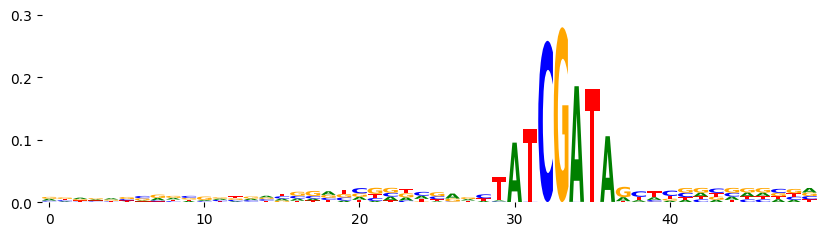

In [94]:
import re
import matplotlib.pyplot as plt
import logomaker
import numpy as np

def read_first_pwm(meme_path):
    pwm = []
    with open(meme_path) as f:
        lines = f.readlines()
    # Find the first "letter-probability matrix" line
    for i, line in enumerate(lines):
        if line.startswith("letter-probability matrix"):
            # Next lines are rows until a blank or non-numeric line
            for row in lines[i+1:]:
                row = row.strip()
                if not row or not re.match(r"^[0-9 .\-]+$", row):
                    break
                pwm.append([float(x) for x in row.split()])
            break
    return np.array(pwm)

# Read and plot
pwm = read_first_pwm("TF-Modisco-lite_results/meme_full_reports/Hk_high_full_report/cwms/raw_cwms.meme")
import pandas as pd
df = pd.DataFrame(pwm, columns=['A','C','G','T'])
df.index.name = 'pos'
logo = logomaker.Logo(df)
logo.style_spines(visible=False)
plt.ylim(0, df.sum(axis=1).max()*1.1)
plt.show()


In [105]:
import numpy as np
from statsmodels.stats.multitest import multipletests

def add_qvals_allow_na(hits, pcol='p-value', qcol='q-value', alpha=0.05):
    for df in hits:
        if pcol not in df:
            # Create the column with NaNs so downstream code always sees it
            df[qcol] = np.nan
            continue

        p = df[pcol].to_numpy(dtype=float)
        mask = np.isfinite(p)  # True where p is valid
        q = np.full_like(p, np.nan, dtype=float)

        if mask.any():
            q_valid = multipletests(p[mask], alpha=alpha, method='fdr_bh')[1]
            q[mask] = q_valid

        df[qcol] = q
    return hits

# Usage:
hits = add_qvals_allow_na(hits, pcol='p-value', qcol='q-value', alpha=0.05)


In [106]:
hits[0]

,motif_name,motif_idx,sequence_name,start,end,strand,score,p-value,q-value
0,pos_patterns.pattern_0,0,0,11,61,+,-3.144645,8.696090e-03,0.009870
1,pos_patterns.pattern_0,0,0,181,231,+,-2.322970,7.160726e-03,0.009870
2,pos_patterns.pattern_0,0,0,114,164,-,1.354449,2.851625e-03,0.007548
3,pos_patterns.pattern_0,0,0,176,226,-,1.774629,2.563636e-03,0.007510
4,pos_patterns.pattern_0,0,0,197,247,-,-0.003861,4.008282e-03,0.009019
5,pos_patterns.pattern_1,1,0,54,104,+,1.567795,1.676299e-03,0.006538
6,pos_patterns.pattern_1,1,0,98,148,+,15.924487,2.118411e-06,0.000048
7,pos_patterns.pattern_1,1,0,106,156,+,-2.502150,5.843657e-03,0.009870
8,pos_patterns.pattern_1,1,0,111,161,+,-4.281316,9.388017e-03,0.009870
9,pos_patterns.pattern_1,1,0,179,229,+,-2.875168,6.368460e-03,0.009870


In [127]:
def collapse_hits_cross_strand(df, overlap_threshold=0.8):
    collapsed = []
    # Group by motif_name only (ignoring strand)
    for motif, group in df.groupby('motif_name'):
        hits = group.sort_values('score', ascending=False).to_dict('records')
        kept = []
        while hits:
            seed = hits.pop(0)
            seed_len = seed['end'] - seed['start']
            merged = False
            for cluster in kept:
                # Compute overlap irrespective of strand
                ov_start = max(seed['start'], cluster['start'])
                ov_end   = min(seed['end'],   cluster['end'])
                if ov_end <= ov_start:
                    continue
                ov_len   = ov_end - ov_start
                shorter = min(seed_len, cluster['end'] - cluster['start'])
                if ov_len / shorter >= overlap_threshold:
                    # Keep the higher-scoring
                    if seed['score'] > cluster['score']:
                        cluster.update(seed)
                    merged = True
                    break
            if not merged:
                kept.append(seed)
        collapsed.extend(kept)
    return pd.DataFrame(collapsed)

# Usage (drops strand when merging):

collapsed_list = [collapse_hits_cross_strand(df, overlap_threshold=0.7) for df in hits]


new_hits = pd.concat(collapsed_list, ignore_index=True)

In [131]:
filtered = new_hits[(new_hits['score'] > 0) & (new_hits['q-value'] < 0.05)]
filtered = filtered.reset_index()


In [134]:
filtered[filtered["sequence_name"] == 33]

,index,motif_name,motif_idx,sequence_name,start,end,strand,score,p-value,q-value
391,957,pos_patterns.pattern_0,0,33,14,64,-,5.673087,0.000831,0.004708
392,958,pos_patterns.pattern_0,0,33,145,195,-,4.042555,0.001357,0.005804
393,959,pos_patterns.pattern_0,0,33,177,227,+,0.448412,0.003613,0.008774
394,961,pos_patterns.pattern_1,1,33,84,134,+,6.673824,0.000249,0.002544
395,962,pos_patterns.pattern_1,1,33,67,117,-,1.616606,0.001621,0.005904
396,965,pos_patterns.pattern_2,2,33,123,173,-,7.068243,0.000445,0.002947
397,966,pos_patterns.pattern_2,2,33,33,83,+,6.989703,0.000462,0.002947
398,967,pos_patterns.pattern_2,2,33,175,225,-,3.885160,0.001384,0.005804
399,968,pos_patterns.pattern_2,2,33,62,112,-,3.653355,0.001479,0.005804
400,969,pos_patterns.pattern_3,3,33,179,229,-,13.249125,0.000013,0.000441


In [48]:
## filter by qval
sum(hits[0]["q-value"] < 0.05)

45

In [ ]:
##TOMTOM-lite
